### 训练中文点选验证码-类型1

使用yolo11n模型进行目标检测

使用vgg16模型训练孪生神经网络

In [ ]:
import sys
import os

# 把当前工作目录添加到sys.path中
sys.path.append(os.path.abspath(".."))

In [ ]:
# 数据集
import my_datasets
from datasets.arrow_dataset import Dataset


dataset: Dataset = my_datasets.get_dataset("captcha_chinese_click_1")
print(dataset)

#### 划分训练集和测试集

In [ ]:
# 数据总共451张验证码图片，比较少，所以测试集比例选择了10%

train_test_dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
train_dataset = train_test_dataset['train']
test_dataset = train_test_dataset['test']
print(train_dataset)
print(test_dataset)

In [ ]:
print(dataset[0])

#### 数据集转换为yolo格式

In [ ]:
from PIL import Image
import os


def toYolo(dataset: Dataset, output_dir):
    # 设置输出目录的位置
    images_dir = os.path.join(output_dir, "images")  # 图片保存目录
    labels_dir = os.path.join(output_dir, "labels")  # 标签保存目录

    # 确保输出目录及其子目录存在
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for idx, data in enumerate(dataset):
        image: Image = data['image']
        objects: object = data['objects']
        bbox: list[list[int]] = objects['bbox']
        # categories: list[int] = objects['categories']

        img_width, img_height = image.size

        image_filename = str(idx) + '.jpg'
        label_filename = str(idx) + '.txt'

        image_filepath = os.path.join(images_dir, image_filename)
        label_filepath = os.path.join(labels_dir, label_filename)

        image.save(image_filepath)

        with open(label_filepath, 'w') as f:
            for idx, box in enumerate(bbox):
                x_min, y_min, x_max, y_max = box
                category = 0 # 默认类别为0
                # category = categories[idx]

                # 将边界框转换为YOLO格式：(class_id, x_center, y_center, width, height)
                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                # 写入标签文件，格式为：class_id x_center y_center width height
                f.write(f"{category} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


root = os.path.abspath("..")
yolo_root = os.path.join(root, "datasets/captcha_chinese_click_1/yolo")
toYolo(dataset=train_dataset, output_dir=os.path.join(yolo_root, "train"))
toYolo(dataset=test_dataset, output_dir=os.path.join(yolo_root, "test"))

#### 训练yolo11n模型

In [ ]:
from ultralytics import YOLO
import yaml

yolo11_model = YOLO(os.path.join(root, "models", "yolo11n.pt"))
train_parms = {
    "train": os.path.abspath(os.path.join(yolo_root, "train")),
    "val": os.path.abspath(os.path.join(yolo_root, "test")),
    "nc": 1,
    "names": ["text"],
}

yaml.dump(train_parms, open(os.path.join(yolo_root, "data.yaml"), "w"))

results = yolo11_model.train(
    pretrained=os.path.join(root, "models", "yolo11n.pt"),
    amp=False,  # 开启自动混合精度训练加速 需要在当前目录下载模型 明明有模型了还要下载 没搞明白为什么不能改目录
    project="captcha_chinese_click_1",
    data=os.path.join(yolo_root, "data.yaml"),
    epochs=100,
    batch=16,
    imgsz=384,
    device="cuda:0",
)

#### 导出yolo模型

In [ ]:
yolo11_model.export(
    file='yolo11n_model.onnx',
    # 动态batch_size
    dynamic=True,
    # 在模型内部开启非极大值抑制，减少后处理的计算量
    nms=True,
)

### 孪生神经网络(其实就是VGG16啦)

简单说一下原理，其实就是 先提取图像的特征，展平出一维特征图，然后求两个特征图之间的欧式距离。

每条训练数据有三个样本，分别为基样本，正向激励样本，反向激励样本

基样本和正向激励样本是同一个文字，反向激励样本是另一个文字

那么loss的规则就是，基样本和正向激励样本距离越大loss越大，基样本和反向激励样本距离越大loss越小

详情请搜索Triplet Loss

In [ ]:
from torch import nn
from torchvision import models, transforms
import torch


class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        # 用了ImageNet上的预训练权重，所以输入的时候要进行标准化
        vgg16 = models.vgg16(weights=models.VGG16_Weights)
        # 把vgg16的平均池化层和分类层去掉, 只保留特征提取层
        del vgg16.classifier
        del vgg16.avgpool
        self.features = vgg16.features
        # 把ImageNet标准化放在模型内部，省得后期调用时再写
        # 输入图片的像素范围是0-255，需要归一化到0-1
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    # 简单吧
    def forward(self, x):
        x = self.normalize(x)
        x = self.features(x)
        # 展平特征图(从第1维开始，因为第0维是batch_size)
        x = torch.flatten(x, start_dim=1)
        return x

### 数据集

In [22]:
import random
from matplotlib import pyplot as plt


class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: Dataset, transform=None):
        """
        Args:
            dataset (Dataset): 包含验证码数据的原始数据集。
            transform (callable, optional): 可选的图像变换方法。
        """
        self.transform = transform
        self.triplets = []  # 存储所有三元组（已裁剪但未应用变换）

        # 遍历原始数据集，生成所有三元组
        for data in dataset:
            image = data['image']  # PIL 图像
            objects = data['objects']
            bboxes = objects['bbox']  # 边界框列表
            categories = objects['categories']  # 分类标签列表

            # 分离题目框和答案框
            question_boxes = [box for box in bboxes if box[1] >= 344]  # y_min >= 344
            answer_boxes = [box for box in bboxes if box[1] < 344]  # y_min < 344

            # 构建类别映射
            category_map = {}
            for i, category in enumerate(categories):
                if category not in category_map:
                    category_map[category] = []
                category_map[category].append(bboxes[i])

            # 遍历每个题目框，生成三元组
            for anchor_box in question_boxes:
                anchor_category = categories[bboxes.index(anchor_box)]  # 基准样本的类别
                positive_boxes = category_map[anchor_category]  # 激励样本（与基准样本同类别）
                positive_boxes = [box for box in positive_boxes if box != anchor_box]
                
                # 如果没有正样本，跳过
                if not positive_boxes:
                    continue

                # 负面样本：从不同类别的答案框中选择
                negative_boxes = [
                    box for i, box in enumerate(answer_boxes)
                    if categories[bboxes.index(box)] != anchor_category
                ]

                # 如果没有负样本，跳过
                if not negative_boxes:
                    continue

                # 随机选择一个正样本和一个负样本
                positive_box = random.choice(positive_boxes)
                negative_box = random.choice(negative_boxes)

                # 裁剪图片
                anchor_image = image.crop(anchor_box)  # 基准样本
                positive_image = image.crop(positive_box)  # 激励样本
                negative_image = image.crop(negative_box)  # 负面样本

                # 存储三元组（已裁剪但未应用变换）
                self.triplets.append((anchor_image, positive_image, negative_image))

    def __getitem__(self, index):
        """
        根据索引获取一组三张图片：基准样本、激励样本和负面样本。
        """
        # 获取存储的三元组信息
        anchor_image, positive_image, negative_image = self.triplets[index]

        # 应用变换
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def __len__(self):
        return len(self.triplets)
    


    def preview(self, num_samples=5):
        """
        随机预览数据集中的若干条数据。
        
        Args:
            num_samples (int): 要预览的样本数量，默认为5。
        """
        # 随机选择若干索引
        indices = random.sample(range(len(self)), num_samples)

        # 创建画布
        fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))
        if num_samples == 1:
            axes = [axes]  # 单一样本时调整形状

        for i, idx in enumerate(indices):
            # 获取三元组
            anchor, positive, negative = self[idx]

            # 将 Tensor 转换为 PIL 图像（如果需要）
            if isinstance(anchor, torch.Tensor):
                anchor = transforms.ToPILImage()(anchor)
                positive = transforms.ToPILImage()(positive)
                negative = transforms.ToPILImage()(negative)

            # 显示图像
            axes[i][0].imshow(anchor)
            axes[i][0].set_title("Anchor")
            axes[i][0].axis('off')

            axes[i][1].imshow(positive)
            axes[i][1].set_title("Positive")
            axes[i][1].axis('off')

            axes[i][2].imshow(negative)
            axes[i][2].set_title("Negative")
            axes[i][2].axis('off')

        plt.tight_layout()
        plt.show()
    

transform = transforms.Compose([
    transforms.Resize((96, 96)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.RandomRotation(10),  # 随机旋转，最大角度为 10 度
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.RandomVerticalFlip(), # 随机垂直翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), # 随机颜色抖动
])

In [23]:
siamese_dataset = SiameseDataset(dataset=dataset, transform=transform)
print(len(siamese_dataset))

1347


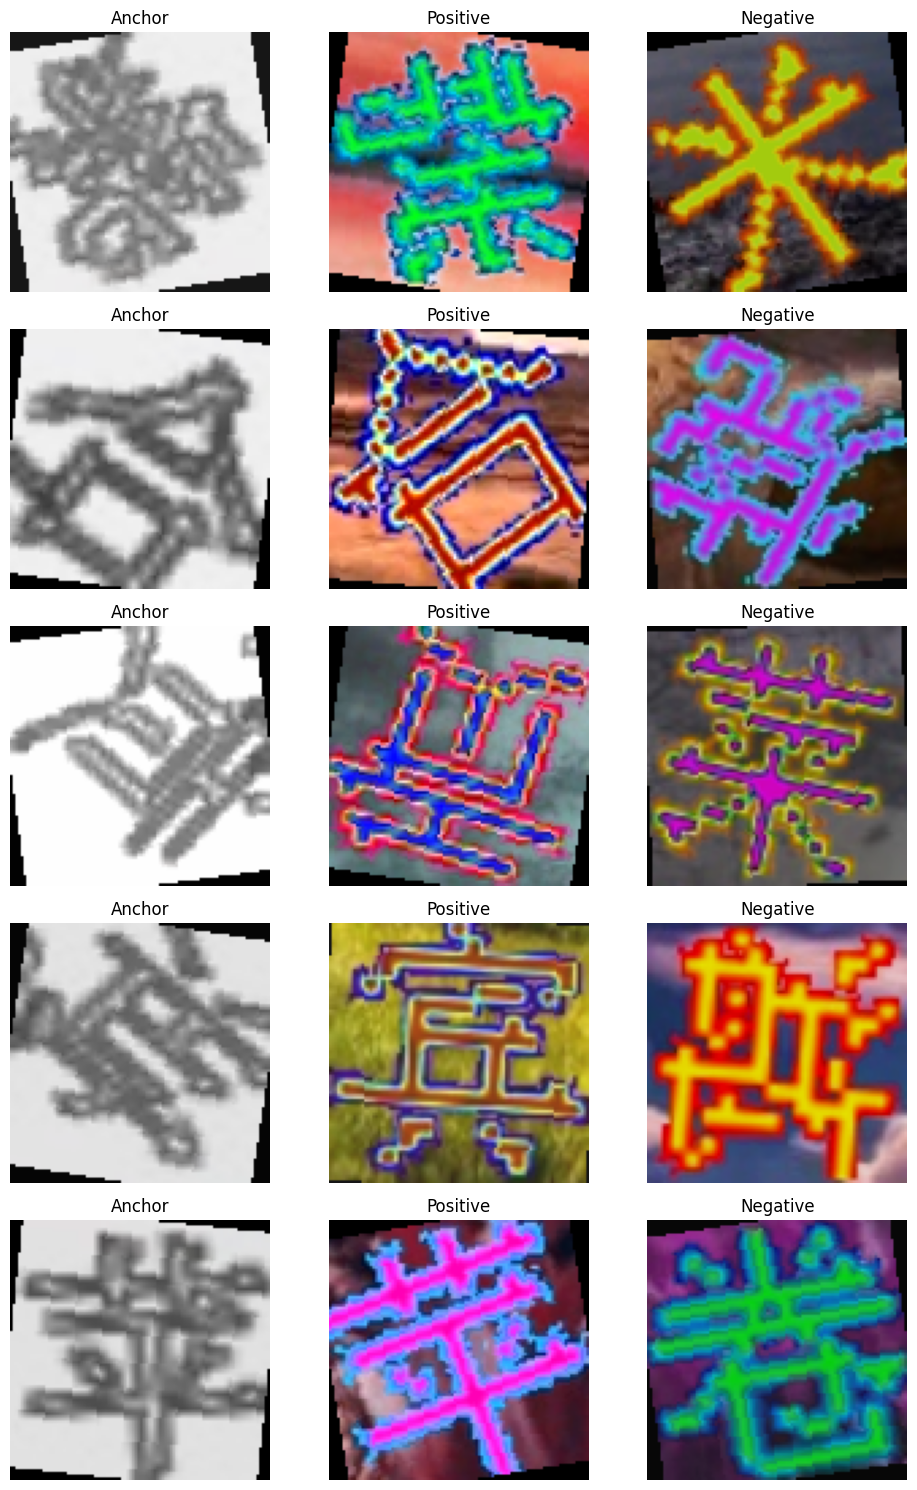

In [27]:
siamese_dataset.preview()